# 3. Correlation between geographic distance and semantic distance

**Authors**

| Author      | Affiliation            |
|-------------|------------------------|
| Rémy Decoupes    | INRAE / TETIS      |
| Mathieu Roche  | CIRAD / TETIS |
| Maguelonne Teisseire | INRAE / TETIS            |

![TETIS](https://www.umr-tetis.fr/images/logo-header-tetis.png)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

/home/rdecoupe/PycharmProjects/geographical-biases-in-LLMs/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Geo Datasets**

In [27]:
!pip install countryinfo
!pip install shapely
!pip install geopandas
!pip install matplotlib
!pip install scikit-learn
!pip install geopy
!pip install plotly-express
!pip install --upgrade nbformat
!pip install unidecode

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.0 MB/s eta 0:00:00a 0:00:01


In [3]:
from countryinfo import CountryInfo
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd

country = CountryInfo()

countries = []
capitals = []
regions = []
subregions = []
coordinates = []

for c in list(country.all().keys()):
    country_info = CountryInfo(c)
    countries.append(c)
    try:
        regions.append(country_info.region())
    except:
        regions.append(np.NAN)
    try:
        subregions.append(country_info.subregion())
    except:
        subregions.append(np.NAN)
    try:
        if country_info.geo_json()["features"][0]["geometry"]["type"] == "Polygon":
          coordinates.append(Polygon(country_info.geo_json()["features"][0]["geometry"]["coordinates"][0]))
        else: #MultiPolygon : Take the biggest one
          polygons = country_info.geo_json()["features"][0]["geometry"]["coordinates"]
          max_polygon = max(polygons, key=lambda x: len(x[0]))
          coordinates.append(Polygon(max_polygon[0]))
    except:
        coordinates.append(np.NAN)
    try:
        capitals.append(country_info.capital())
    except:
        capitals.append(np.NAN)

# Create DataFrame
data = {
    'Country': countries,
    'Capital': capitals,
    'Region': regions,
    'Subregion': subregions,
    'Coordinates': coordinates
}

df_countries = pd.DataFrame(data)
df_countries = gpd.GeoDataFrame(df_countries, geometry='Coordinates')

**add Captials coordinates**

With OpenStreetMap data through Nominatim geocoders

In [4]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point

geolocator = Nominatim(user_agent="geoBias-llm")
location = geolocator.geocode("Taipei", language='en')

print(f"lat: {location.latitude}, lon: {location.longitude}")

def capital_coord(city):
    loc = geolocator.geocode(city, language='en')
    try:
        point = Point(loc.longitude, loc.latitude)
    except:
        point = np.nan
    return point

df_countries["capital_coordinates"] = df_countries["Capital"].apply(capital_coord)

# Change the geometry
df_countries = gpd.GeoDataFrame(df_countries, geometry="capital_coordinates")

lat: 25.0375198, lon: 121.5636796


In [5]:
df_countries

Country          Capital    Region         Subregion  \
0        saint helena        Jamestown    Africa    Western Africa   
1    marshall islands           Majuro   Oceania        Micronesia   
2        saudi arabia           Riyadh      Asia      Western Asia   
3       united states  Washington D.C.  Americas  Northern America   
4          mozambique           Maputo    Africa    Eastern Africa   
..                ...              ...       ...               ...   
229          guernsey   St. Peter Port    Europe   Northern Europe   
230          kiribati     South Tarawa   Oceania        Micronesia   
231            angola           Luanda    Africa     Middle Africa   
232        seychelles         Victoria    Africa    Eastern Africa   
233            kuwait      Kuwait City      Asia      Western Asia   

                                           Coordinates  \
0                                                 None   
1                                                 None   
2    POLYGON ((42.77933 16.34789, 42.64957 16.77463...   
3    POLYGON ((-94.81758 49.38905, -94.64000 48.840...   
4    POLYGON ((34.55999 -11.52002, 35.31240 -11.439...   
..                                                 ...   
229                                               None   
230                                               None   
231  POLYGON ((16.32653 -5.87747, 16.57318 -6.62265...   
232                                               None   
233  POLYGON ((47.97452 29.97582, 48.18319 29.53448...   

             capital_coordinates  
0     POINT (-76.77830 37.20892)  
1      POINT (171.38164 7.09099)  
2      POINT (46.71601 24.63892)  
3     POINT (-77.03654 38.89504)  
4     POINT (32.56745 -25.96621)  
..                           ...  
229    POINT (-2.53900 49.45681)  
230    POINT (173.03865 1.34908)  
231    POINT (13.24395 -8.82727)  
232  POINT (144.67801 -36.59861)  
233    POINT (47.97342 29.37965)  

[234 rows x 6 columns]

/tmp/ipykernel_32049/2968476385.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

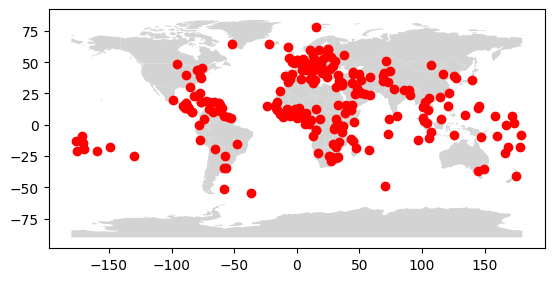

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax =  world.plot(color='lightgrey')

df_countries.plot(ax=ax, color="red")

## 3.1 SLMs

### 3.1.1 Example

Let's compute the correlation between Taepei and other cities

In [7]:
city1 = "Taipei"
city2 = "Seoul"
city3 = "Hanoi"
city4 = "Tokyo"
city5 = "Singapour"
city6 = "London"

Retrieve **word embedding** from city names

In [8]:
from transformers import RobertaTokenizer, RobertaModel

model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def word_embedding(input_text):
    try:
        input_ids = tokenizer.encode(input_text, return_tensors="pt")
        with torch.no_grad():
            last_hidden_states = model(input_ids).last_hidden_state
        return last_hidden_states.mean(dim=1)[0] # for words chunked into subtokens (out of model vocabulary) and [CLS] & [SEP]
    except:
        return np.nan

emb1 = word_embedding(city1)
emb2 = word_embedding(city2)
emb3 = word_embedding(city3)
emb4 = word_embedding(city4)
emb5 = word_embedding(city5)
emb6 = word_embedding(city6)

print(f"Embedding length: {emb1.shape} \n\t{emb1}")

Embedding length: torch.Size([768]) 
	tensor([-1.0344e-01,  8.8463e-02,  6.6635e-02,  2.0099e-02,  3.6651e-01,
        -5.1789e-01, -7.1481e-02,  1.0918e-01, -7.7129e-02,  4.6443e-02,
        -5.2158e-01, -4.2303e-01,  8.9081e-02, -1.0026e-01, -5.2531e-02,
        -2.0453e-01, -1.3157e-01,  1.8711e-01,  5.5865e-02, -2.1894e-01,
        -2.3988e-02,  6.2741e-02,  7.7269e-04, -2.8513e-02, -1.3359e-01,
         5.7200e-02,  1.9231e-01,  1.6754e-01,  9.0532e-02,  1.2666e-01,
        -1.3217e-01,  5.1488e-02,  2.1087e-01, -1.2752e-01,  1.5219e-01,
         3.4347e-02,  1.7878e-01,  1.0780e-01, -7.2472e-02,  5.6217e-02,
        -1.1494e-01,  2.1247e-02, -1.3130e-02,  2.7331e-02,  6.7226e-02,
        -9.3472e-02,  9.6714e-02, -9.3964e-02, -3.2711e-02, -2.0009e-01,
         2.2984e-02,  7.8440e-02, -1.5559e-01, -1.1185e-01, -1.1732e-01,
         1.9455e-01,  1.0967e-01,  4.4959e-02, -1.1554e-02, -8.2157e-02,
         2.8651e-02,  8.2192e-01,  3.0873e-02, -1.1618e-01,  8.4376e-02,
        -3.98

Compute **semantic similarity** between the cities' embedding

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

print(f"Similarity between {city1} and {city2}: {cosine_similarity([emb1], [emb2])}")
print(f"Similarity between {city1} and {city3}: {cosine_similarity([emb1], [emb3])}")
print(f"Similarity between {city1} and {city4}: {cosine_similarity([emb1], [emb4])}")
print(f"Similarity between {city1} and {city5}: {cosine_similarity([emb1], [emb5])}")
print(f"Similarity between {city1} and {city6}: {cosine_similarity([emb1], [emb6])}")

Similarity between Taipei and Seoul: [[0.9458187]]
Similarity between Taipei and Hanoi: [[0.94002295]]
Similarity between Taipei and Tokyo: [[0.95521307]]
Similarity between Taipei and Singapour: [[0.9291067]]
Similarity between Taipei and London: [[0.93424034]]


Compute **geodistance** between cities

In [11]:
from geopy.distance import geodesic

geo_coord_1 = capital_coord(city1)
geo_coord_2 = capital_coord(city2)
geo_coord_3 = capital_coord(city3)
geo_coord_4 = capital_coord(city4)
geo_coord_5 = capital_coord(city5)
geo_coord_6 = capital_coord(city6)

# distance = geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_2.xy[1][0], geo_coord_2.xy[0][0])).kilometers

print(f"Distance between {city1} and {city2}: {geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_2.xy[1][0], geo_coord_2.xy[0][0])).kilometers} km")
print(f"Distance between {city1} and {city3}: {geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_3.xy[1][0], geo_coord_3.xy[0][0])).kilometers} km")
print(f"Distance between {city1} and {city4}: {geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_4.xy[1][0], geo_coord_4.xy[0][0])).kilometers} km")
print(f"Distance between {city1} and {city5}: {geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_5.xy[1][0], geo_coord_5.xy[0][0])).kilometers} km")
print(f"Distance between {city1} and {city6}: {geodesic((geo_coord_1.xy[1][0], geo_coord_1.xy[0][0]), (geo_coord_6.xy[1][0], geo_coord_6.xy[0][0])).kilometers} km")


Distance between Taipei and Seoul: 1480.973652900838 km
Distance between Taipei and Hanoi: 1669.0557310016254 km
Distance between Taipei and Tokyo: 2104.49710309371 km
Distance between Taipei and Singapour: 3244.7170452369037 km
Distance between Taipei and London: 9805.447557804078 km


### 1.1.2 On the whole world

Build 2 matrices between pairs of Capitals:
- Semantic distance (1 - cosine similarity)
- Geo distance

In [12]:
# drop row for which we could not find geo coordinates
df_countries = df_countries[df_countries["capital_coordinates"].notna()]
df_countries["capital_coordinates"]


def tensor_to_array(embedding):
    try:
        return embedding.numpy()
    except:
        return np.nan

df_countries["capital_embedding_tensor"] = df_countries["Capital"].apply(word_embedding)
df_countries["capital_embedding"] = df_countries["capital_embedding_tensor"].apply(tensor_to_array)
df_countries = df_countries.dropna(subset=["capital_embedding"])

embedding_array = np.stack(df_countries["capital_embedding"].values)
semantic_distance_matrix = 1 - cosine_similarity(embedding_array, embedding_array)

/home/rdecoupe/PycharmProjects/geographical-biases-in-LLMs/.conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rdecoupe/PycharmProjects/geographical-biases-in-LLMs/.conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
def compute_geo_distance(df):
    coordinates = df["capital_coordinates"].tolist()
    num_city = len(coordinates)

    # Create an empty distance matrix
    distance_matrix = np.zeros((num_city, num_city))

    # Calculate distances and populate the distance matrix
    for i in range(num_city):
        for j in range(i + 1, num_city):
            coord1 = (coordinates[i].xy[1][0], coordinates[i].xy[0][0])
            coord2 = (coordinates[j].xy[1][0], coordinates[j].xy[0][0])
            distance = geodesic(coord1, coord2).kilometers
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Since the distance matrix is symmetric
    return distance_matrix

geo_distance_matrix = compute_geo_distance(df_countries)


In [52]:
from unidecode import unidecode
import plotly.express as px
from scipy.stats import linregress

def label_for_plotting(df):
    capital = df["Capital"].tolist()
    num_capital = len(capital)

    # Create an empty distance matrix
    label_matrix = np.chararray((num_capital, num_capital), itemsize=30, unicode=True)

    # Calculate distances and populate the distance matrix
    for i in range(num_capital):
        for j in range(i + 1, num_capital):
            coord1 = unidecode(capital[i])
            coord2 = unidecode(capital[j])
            try:
                label_matrix[i, j] = f"{coord1} - {coord2}"
                label_matrix[j, i] = f"{coord1} - {coord2}"
            except:
                print(f"{coord1} - {coord2}")
    return label_matrix

labels_hover = label_for_plotting(df_countries)

def plot_scatter(geo_distance_matrix, semantic_distance_matrix, labels_hover, title):

    df = pd.DataFrame({
        "Geo Distance": geo_distance_matrix.flatten(),
        "Semantic Distance": semantic_distance_matrix.flatten(),
        "labels": labels_hover.flatten()
    })
    df["labels"].astype('str')

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(df["Geo Distance"], df["Semantic Distance"])
    line = slope * df["Geo Distance"] + intercept

    # Plot with Plotly Express
    fig = px.scatter(df, x="Geo Distance", y="Semantic Distance", title=title,
                        trendline="ols", trendline_color_override="red",
                        labels={"Geo Distance": "Geo Distance", "Semantic Distance": "Semantic Distance"},
                        hover_name="labels"
                        )

    # Add R-squared value to the layout
    fig.update_layout(annotations=[
        dict(
            x=0.05,
            y=0.95,
            xref="paper",
            yref="paper",
            text=f'R2 = {r_value**2:.2f}',
            showarrow=False,
            font=dict(size=12),
            bgcolor="rgba(255, 255, 255, 0.6)"
        )
    ])

plot_scatter(geo_distance_matrix, semantic_distance_matrix, labels_hover, "World")
fig.show()

In [ ]:
for region in df_countries["Region"].unique():
    print(region)
    df = df_countries[df_countries["Region"] == region]
    embedding_array = np.stack(df["capital_embedding"].values)
    semantic_distance_matrix = 1 - cosine_similarity(embedding_array, embedding_array)
    geo_distance_matrix = compute_geo_distance(df)
    labels_hover = label_for_plotting(df)
    plot_scatter(geo_distance_matrix, semantic_distance_matrix, labels_hover,region)